In [68]:
import re
import string
from collections import Counter, defaultdict
import spacy
import textstat
import sqlite3
import json
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np
import random
from pathlib import Path

In [17]:
# Load a small English model for spaCy
nlp = spacy.load("en_core_web_sm")

# A list of common English function words.
FUNCTION_WORDS = {
	"the", "be", "to", "of", "and", "a", "in", "that", "have", "I",
	"for", "not", "on", "with", "he", "as", "you", "do", "at", "this",
	"but", "his", "by", "from", "they", "we", "say", "her", "she",
	"or", "an", "will", "my", "one", "all", "would", "there", "their"
}

def syllable_count(word):
	"""Approximate the number of syllables in a word."""
	word = word.lower()
	# A simple heuristic to estimate syllables.
	# There are more accurate methods, but this suffices for a rough measure.
	count = 0
	vowels = 'aeiou'
	# Count vowel groups
	previous_was_vowel = False
	for char in word:
		if char in vowels:
			if not previous_was_vowel:
				count += 1
			previous_was_vowel = True
		else:
			previous_was_vowel = False
	# Remove es and ed endings as extra syllables if they were counted
	if word.endswith('es') or word.endswith('ed'):
		count = max(count - 1, 1)
	return max(count, 1)  # At least one syllable

def get_char_bigrams(text):
	clean_text = re.sub(r'\s+', ' ', text)
	return [clean_text[i:i+2] for i in range(len(clean_text)-1)]

In [ ]:
"""CREATE TABLE IF NOT EXISTS civitai (
	id INTEGER PRIMARY KEY,
	url TEXT NOT NULL,
	width INTEGER NOT NULL,
	height INTEGER NOT NULL,
	nsfw BOOLEAN NOT NULL,
	nsfwLevel TEXT NOT NULL,
	createdAt TEXT NOT NULL,
	postId INTEGER NOT NULL,
	cryCount INTEGER NOT NULL,
	laughCount INTEGER NOT NULL,
	likeCount INTEGER NOT NULL,
	heartCount INTEGER NOT NULL,
	commentCount INTEGER NOT NULL,
	meta TEXT NOT NULL,
	username TEXT,
	imported BOOLEAN
);"""
civitai_conn = sqlite3.connect('civitai.sqlite')
civitai_cursor = civitai_conn.cursor()
civitai_cursor.execute('SELECT meta FROM civitai WHERE meta != "null"')

unextracted = []
all_prompts = set()

for row in tqdm(civitai_cursor.fetchall()):
	meta = row[0]
	try:
		meta = json.loads(meta)
	except:
		unextracted.append(meta)
		continue

	if 'prompt' in meta:
		prompt = meta['prompt']
		all_prompts.add(prompt.strip())

print(f"Total prompts: {len(all_prompts)}")
print(f"Unextracted: {len(unextracted)}")

In [ ]:
all_bigrams = Counter()
for txt in all_prompts:
	bigrams = get_char_bigrams(txt)
	all_bigrams.update(bigrams)

# Select the top N bigrams
top_bigrams = [bg for bg, count in all_bigrams.most_common(100)]

In [32]:
def extract_stylistic_features(text, bigram_vocab=None):
	# Process text with spaCy
	doc = nlp(text)

	# Extract tokens that are words (excluding punctuation, spaces, etc.)
	words = [token.text for token in doc if token.is_alpha]
	sentences = list(doc.sents)
	chars = list(text)

	# Basic counts
	num_sentences = len(sentences) if len(sentences) > 0 else 1
	num_words = len(words) if len(words) > 0 else 1
	num_chars = sum(len(w) for w in words)

	# Lexical features
	word_lengths = [len(w) for w in words]
	avg_word_length = sum(word_lengths) / num_words if num_words > 0 else 0
	word_length_variance = 0.0
	if num_words > 1:
		mean_wl = avg_word_length
		word_length_variance = sum((wl - mean_wl)**2 for wl in word_lengths) / (num_words - 1)

	# Type-token ratio
	unique_words = set(w.lower() for w in words)
	ttr = len(unique_words) / num_words if num_words > 0 else 0

	# Sentence length features
	sentence_lengths = [len([t for t in s if t.is_alpha]) for s in sentences]
	avg_sentence_length = sum(sentence_lengths)/num_sentences if num_sentences > 0 else 0
	sentence_length_variance = 0.0
	if num_sentences > 1:
		mean_sl = avg_sentence_length
		sentence_length_variance = sum((sl - mean_sl)**2 for sl in sentence_lengths) / (num_sentences - 1)

	# POS tag distribution
	pos_counts = Counter([token.pos_ for token in doc if token.is_alpha])
	total_pos = sum(pos_counts.values()) if sum(pos_counts.values()) > 0 else 1

	# Function word frequency
	lower_words = [w.lower() for w in words]
	fw_counts = Counter(lower_words)
	total_fw = sum(fw_counts[w] for w in FUNCTION_WORDS)
	relative_function_word_freq = total_fw / num_words if num_words > 0 else 0

	# Punctuation usage
	punctuation_counts = Counter(ch for ch in text if ch in string.punctuation)

	# Syllable-based measures
	word_syllables = [syllable_count(w) for w in words]
	avg_syllables_per_word = sum(word_syllables)/num_words if num_words>0 else 0

	# Readability scores (using textstat)
	flesch_reading_ease = textstat.flesch_reading_ease(text)
	flesch_kincaid_grade = textstat.flesch_kincaid_grade(text)
	smog_index = textstat.smog_index(text)
	gunning_fog = textstat.gunning_fog(text)
	coleman_liau_index = textstat.coleman_liau_index(text)
	automated_readability_index = textstat.automated_readability_index(text)
	dale_chall = textstat.dale_chall_readability_score(text)

	# Combine all features into a dictionary
	features = {
		# Basic counts
		"num_words": num_words,
		"num_sentences": num_sentences,
		
		# Lexical
		"avg_word_length": avg_word_length,
		"word_length_variance": word_length_variance,
		"type_token_ratio": ttr,
		
		# Sentence
		"avg_sentence_length": avg_sentence_length,
		"sentence_length_variance": sentence_length_variance,
		
		# Function words
		"function_word_frequency": relative_function_word_freq,
		
		# Syllable measure
		"avg_syllables_per_word": avg_syllables_per_word,
		
		# Readability scores
		"flesch_reading_ease": flesch_reading_ease,
		"flesch_kincaid_grade": flesch_kincaid_grade,
		"smog_index": smog_index,
		"gunning_fog": gunning_fog,
		"coleman_liau_index": coleman_liau_index,
		"automated_readability_index": automated_readability_index,
		"dale_chall": dale_chall,
	}

	# POS tag distribution
	ALL_POS_TAGS = [
		"ADJ", "ADP", "ADV", "AUX", "CONJ", "CCONJ", "DET", "INTJ", "NOUN", "NUM",
		"PART", "PRON", "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X"
	]

	for pos in ALL_POS_TAGS:
		count = pos_counts.get(pos, 0)
		features[f"pos_freq_{pos}"] = count / total_pos

	# Punctuation frequencies
	safe_num_words = num_words if num_words > 0 else 1
	for p in string.punctuation:
		count = punctuation_counts[p] if p in punctuation_counts else 0
		features[f"punct_freq_{p}"] = count / safe_num_words

	# Character-level features
    # Let's extract character bigrams
	char_bigrams = get_char_bigrams(text)
	bigram_counts = Counter(char_bigrams)
	total_bigrams = sum(bigram_counts.values()) if bigram_counts else 1

	if bigram_vocab is not None:
		for bg in bigram_vocab:
			features[f"char_bigram_freq_{bg}"] = bigram_counts[bg] / total_bigrams
	else:
		pass

	return features


sample_text = """This is a simple example text. It is meant to demonstrate stylistic feature extraction.
Notice how punctuation, word length, and sentence structure may vary between texts."""
feats = extract_stylistic_features(sample_text, top_bigrams)
for k, v in feats.items():
	print(k, ":", v)

num_words : 26
num_sentences : 3
avg_word_length : 5.423076923076923
word_length_variance : 8.653846153846155
type_token_ratio : 0.9615384615384616
avg_sentence_length : 8.666666666666666
sentence_length_variance : 9.333333333333332
function_word_frequency : 0.15384615384615385
avg_syllables_per_word : 1.7692307692307692
flesch_reading_ease : 62.64
flesch_kincaid_grade : 6.7
smog_index : 8.8
gunning_fog : 8.1
coleman_liau_index : 12.08
automated_readability_index : 9.4
dale_chall : 10.14
pos_freq_ADJ : 0.07692307692307693
pos_freq_ADP : 0.038461538461538464
pos_freq_ADV : 0.0
pos_freq_AUX : 0.11538461538461539
pos_freq_CONJ : 0.0
pos_freq_CCONJ : 0.038461538461538464
pos_freq_DET : 0.038461538461538464
pos_freq_INTJ : 0.0
pos_freq_NOUN : 0.38461538461538464
pos_freq_NUM : 0.0
pos_freq_PART : 0.038461538461538464
pos_freq_PRON : 0.07692307692307693
pos_freq_PROPN : 0.038461538461538464
pos_freq_PUNCT : 0.0
pos_freq_SCONJ : 0.038461538461538464
pos_freq_SYM : 0.0
pos_freq_VERB : 0.115384

In [33]:
all_data = []

for prompt in tqdm(all_prompts):
	feats = extract_stylistic_features(prompt, top_bigrams)
	all_data.append({
		"prompt": prompt,
		"features": feats,
	})

100%|██████████| 69194/69194 [12:34<00:00, 91.76it/s]  


In [31]:
all_data[0]

{'prompt': 'real, atmospheric scene, masterpiece, best quality, (detailed face, detail skin texture, ultra-detailed body),(cinematic light:1.1), 1girl, bttflorraine-smf, smile, realistic, grin, breasts, bare shoulders, cleavage, dress, black hair, solo focus, brown hair, strapless, medium breasts, lips, real life insert, pink dress <lora:backtothefuture_lorraine_lora_smf_01:0.9>',
 'features': {'num_words': 39,
  'num_sentences': 1,
  'avg_word_length': 5.897435897435898,
  'word_length_variance': 5.3049932523616805,
  'type_token_ratio': 0.8717948717948718,
  'avg_sentence_length': 39.0,
  'sentence_length_variance': 0.0,
  'pos_freq_ADJ': 0.38461538461538464,
  'pos_freq_NOUN': 0.5384615384615384,
  'pos_freq_PROPN': 0.07692307692307693,
  'function_word_frequency': 0.0,
  'avg_syllables_per_word': 1.794871794871795,
  'flesch_reading_ease': 25.8,
  'flesch_kincaid_grade': 14.6,
  'smog_index': 0.0,
  'gunning_fog': 15.0,
  'coleman_liau_index': 25.23,
  'automated_readability_index'

In [34]:
df = pd.DataFrame([item["features"] for item in all_data])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)
print(scaled_features.shape)

scaled_df = pd.DataFrame(scaled_features, columns=df.columns)
scaled_df

(69194, 166)


num_words  num_sentences  avg_word_length  word_length_variance  \
0      -0.180893      -0.283404         0.771401             -0.043142   
1      -0.562361      -0.283404        -8.229486             -1.386490   
2      -0.351550      -0.283404         1.413559              0.262750   
3      -0.371627      -0.283404         1.080562             -0.136366   
4       0.039957      -0.283404         0.077249             -0.402932   
...          ...            ...              ...                   ...   
69189   0.371231      -0.283404        -0.387224             -0.250519   
69190  -0.301356      -0.020266        -1.389681             -0.697520   
69191  -0.110623      -0.283404         1.292908              0.450052   
69192   0.120266      -0.283404         0.109521             -0.495891   
69193  -0.281279      -0.283404         1.085825             -0.313097   

       type_token_ratio  avg_sentence_length  sentence_length_variance  \
0              0.249095             0.091864                 -0.027033   
1             -7.465739            -1.236617                 -0.027033   
2              0.981385            -0.487217                 -0.027033   
3              0.941161            -0.555345                 -0.027033   
4              0.368128             0.841263                 -0.027033   
...                 ...                  ...                       ...   
69189         -0.028504             1.965363                 -0.027033   
69190          0.400366            -0.776758                 -0.026935   
69191         -0.540147             0.330309                 -0.027033   
69192         -1.822664             1.113772                 -0.027033   
69193          0.773328            -0.248772                 -0.027033   

       function_word_frequency  avg_syllables_per_word  flesch_reading_ease  \
0                    -1.101315                0.461159            -0.123350   
1                    -1.101315               -7.329698             3.177128   
2                    -0.719327                0.562338            -0.296177   
3                    -1.101315                0.483418             0.178914   
4                    -0.136952               -0.071612            -0.394622   
...                        ...                     ...                  ...   
69189                -0.117899               -0.864945             0.364685   
69190                -0.167567               -1.059913             0.903765   
69191                -0.005176                0.691013            -0.379491   
69192                -0.979522               -0.032424            -0.728061   
69193                -1.101315                0.453483            -0.135747   

       ...  char_bigram_freq_wi  char_bigram_freq_of  char_bigram_freq_ho  \
0      ...            -0.695055            -0.684310            -0.134455   
1      ...            -0.695055            -0.684310            -0.787097   
2      ...            -0.695055             1.598209            -0.787097   
3      ...            -0.695055            -0.684310            -0.787097   
4      ...            -0.223185            -0.251788            -0.336492   
...    ...                  ...                  ...                  ...   
69189  ...            -0.383012            -0.398287             0.106845   
69190  ...            -0.695055            -0.684310            -0.787097   
69191  ...            -0.695055             0.390443            -0.787097   
69192  ...            -0.695055            -0.684310             2.121565   
69193  ...            -0.695055             0.363574             0.304596   

       char_bigram_freq_ve  char_bigram_freq_p,  char_bigram_freq_ow  \
0                -0.802422            -0.642685            -0.044840   
1                -0.802422            -0.642685            -0.690976   
2                -0.802422            -0.642685             0.486143   
3                -0.802422             0.934763            -0.69097

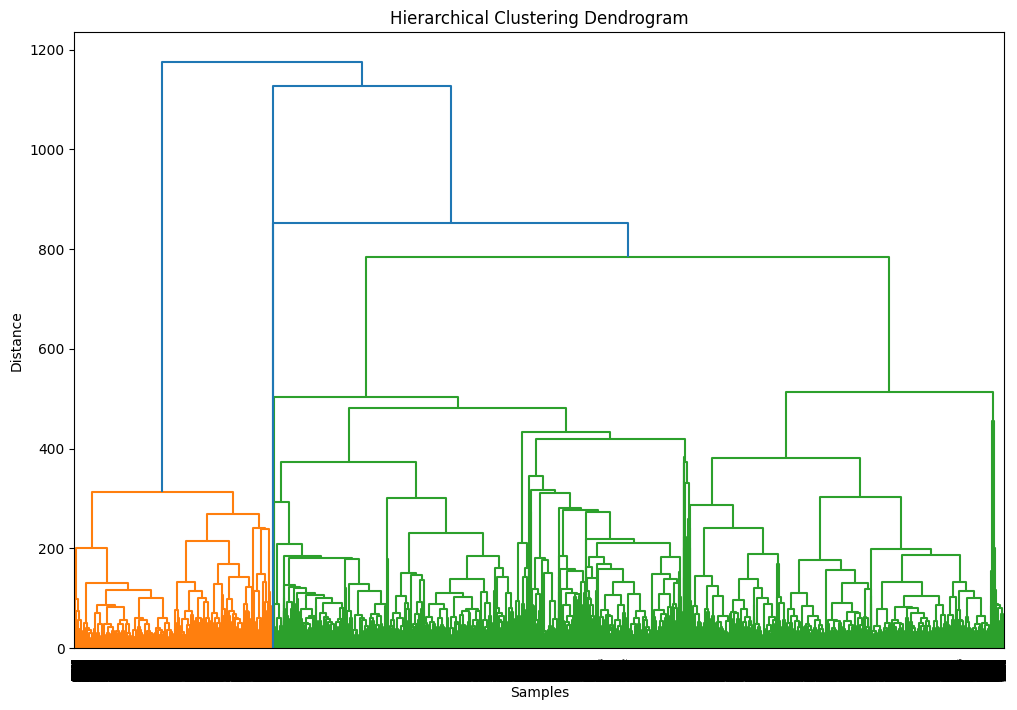

In [53]:
# Perform hierarchical clustering using Ward's method (commonly used)
#foo = np.random.choice(scaled_features.shape[0], 16000, replace=False)
Z = linkage(scaled_features, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

In [65]:
clusters = fcluster(Z, t=300, criterion='distance')

In [67]:
by_cluster = defaultdict(list)
#for i, idx in enumerate(foo):
for idx in range(len(all_data)):
	cluster = clusters[idx]
	prompt = all_data[idx]['prompt']
	by_cluster[cluster].append(prompt)

for cluster, prompts in by_cluster.items():
	print(f"Cluster {cluster} ({len(prompts)} prompts):")
	for p in prompts[:5]:
		print(f"  {p[:50]}...")
	print()

Cluster 5 (9406 prompts):
  real, atmospheric scene, masterpiece, best quality...
  pixar style of  walrus,  as a pixar character,   c...
  sinister, eerie, dark, shadow, distorted, grainy, ...
  1woman, solo,  long hair, pink hair, black choker,...
  orange peel, bright lights, ultra realistic, space...

Cluster 11 (9276 prompts):
  ...
  Medium Otherworldly Anomalous Textured Arachnid,  ...
  score_9, score_8_up, score_7_up, score_6_up, sourc...
  from front,1girl,random fictional girl named Maya ...
  masterpiece, best quality, illustration, 1boy, sol...

Cluster 19 (7157 prompts):
  score_9, score_8_up, score_7_up, best quality,  ro...
  score_9, score_8_up, score_7_up, score_6_up, score...
  (score_9, score_8_up, score_7_up, score_6_up, scor...
  score_9, score_8_up, score_7_up, BREAK
(first pers...
  safe_pos, Expressiveh, score_9, score_8_up, score_...

Cluster 21 (8946 prompts):
  (score_9, score_8_up, score_7_up), 1girl, white ha...
  safe_pos, Warcraft style, masterpiece, sco

In [70]:
Path("prompts_by_cluster.json").write_text(json.dumps({str(k): v for k, v in by_cluster.items()}, indent=2))

31756622

In [78]:
def remove_loras(prompt: str) -> str:
	# Remove LoRA tags of the form <lora:something>
	return re.sub(r"<lora:[^>]+>", "", prompt)

def remove_scaling_factors(text: str) -> str:
	# Remove trailing scaling factors like :1.2, :0.5, etc.
	# This matches a colon followed by a number (possibly with a decimal) at the end of the string
	return re.sub(r":\s*\d+(\.\d+)?\s*$", "", text.strip())

def strip_brackets(prompt: str) -> str:
	result = ""
	stack = []

	for ch in prompt:
		if ch in "([":
			stack.append(ch)
		elif len(stack) > 0 and ((stack[-1][0] == "(" and ch == ")") or (stack[-1][0] == "[" and ch == "]")):
			inner = stack.pop()[1:]
			# Remove scaling factors from inner
			inner = remove_scaling_factors(inner)
			
			if len(stack) > 0:
				stack[-1] += inner
			else:
				result += inner
		elif len(stack) > 0:
			stack[-1] += ch
		else:
			result += ch
	
	# Handle any dangling brackets
	while len(stack) > 0:
		inner = stack.pop()
		if len(stack) > 0:
			stack[-1] += inner
		else:
			result += inner

	return result

def clean_prompt(prompt: str) -> str:
	prompt = remove_loras(prompt)
	prompt = strip_brackets(prompt)
	# Cleanup extra whitespace
	#prompt = re.sub(r"\s+", " ", prompt).strip()
	return prompt

# Test the given prompt
test_prompt = "(((A  movie poster for 'A Zoom Interview with a Vampire.')) Include the zoom logo. <lora:myLora:0.8>)"
print(clean_prompt(test_prompt))
test_prompt = "(A movie:1.2) poster for 'A Zoom Interview with a Vampire.' Include the zoom logo."
print(clean_prompt(test_prompt))
test_prompt = "(A movie : 1.8 ) poster for 'A Zoom Interview with a Vampire.' (Include the zoom logo."
print(clean_prompt(test_prompt))

A  movie poster for 'A Zoom Interview with a Vampire.' Include the zoom logo.
A movie poster for 'A Zoom Interview with a Vampire.' Include the zoom logo.
A movie  poster for 'A Zoom Interview with a Vampire.' (Include the zoom logo.


In [80]:
for k in sorted(by_cluster.keys()):
	if len(by_cluster[k]) < 64:
		continue

	prompts = random.sample(by_cluster[k], 8)
	prompts = [clean_prompt(p) for p in prompts]

	print(f"Cluster {k}:\n```")
	print(json.dumps(prompts, indent=2))
	print("```")
	print()

Cluster 1:
```
[
  "A tiny mouse stands on a colorful pile of fresh fruits in a bustling outdoor market. The mouse holds a small, red tomato with both paws, nibbling it eagerly. Sunlight filters through the scene, highlighting the vibrant colors of oranges, limes, and tomatoes around it. The mouse\u2019s big eyes look up occasionally, wide with excitement and curiosity. Background figures of market-goers pass by in a blur, emphasizing the mouse\u2019s small size and playful, sneaky demeanor as it enjoys its snack undisturbed",
  "A 45 years old slightly overweight woman stands in front of a mirror, capturing a selfie. The image quality is grainy, with a slight blur softening the details. The lighting is dim, casting shadows that obscure her features. The room is cluttered, with clothes strewn across the bed and an unmade blanket. Her expression is casual, full of concentration, while the old iPhone struggles to focus, giving the photo an authentic, unpolished feel. The mirror shows smu